# 4. Application - Quantum Phase Estimation

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 Qiskit에서 제공하는 양자알고리즘 솔루션 중 하나인 Quantum Phase Estimation을 활용한다.

### 0. 필요한 요소 불러오기

In [97]:
import numpy as np

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.phase_estimators import PhaseEstimation
from qiskit.providers.aer import AerProvider
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import QuantumInstance

### 1. Quantum Phase Estimation

Quantum phase estimation은 Quantum Fourier Transform을 활용하여 Exponential speed-up을 달성하는
양자 알고리즘으로, 주어진 unitary matrix의 eigen phase를 계산한다.
[(참고자료)](https://quantum-computing.ibm.com/composer/docs/iqx/guide/quantum-phase-estimation)

먼저, Eigen phase를 계산할 unitary 회로를 준비한다.

depth =  3


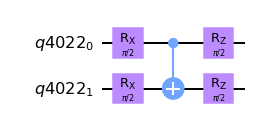

In [98]:
num_unitary_qubits = 2

unitary_qubit = QuantumRegister(num_unitary_qubits)
unitary_circuit = QuantumCircuit(unitary_qubit)
for i in range(num_unitary_qubits):
    unitary_circuit.rx(0.5*np.pi, i)
for i in range(num_unitary_qubits - 1):
    unitary_circuit.cx(i, i+1)
for i in range(num_unitary_qubits):
    unitary_circuit.rz(0.5*np.pi, i)

print("depth = ", unitary_circuit.depth())
unitary_circuit.draw('mpl');

다음으로, 초기 상태를 준비하기 위한 회로를 준비한다. 이 때, 초기 상태는 관심있는 eigen state와 overlap이 많을 것으로 가정한다.

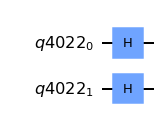

In [99]:
state_prep = QuantumCircuit(unitary_qubit)
state_prep.h(unitary_qubit)
state_prep.draw('mpl');

evaluation qubit의 갯수를 지정하고, Phase Estimation 회로를 구현한다.

depth = 122


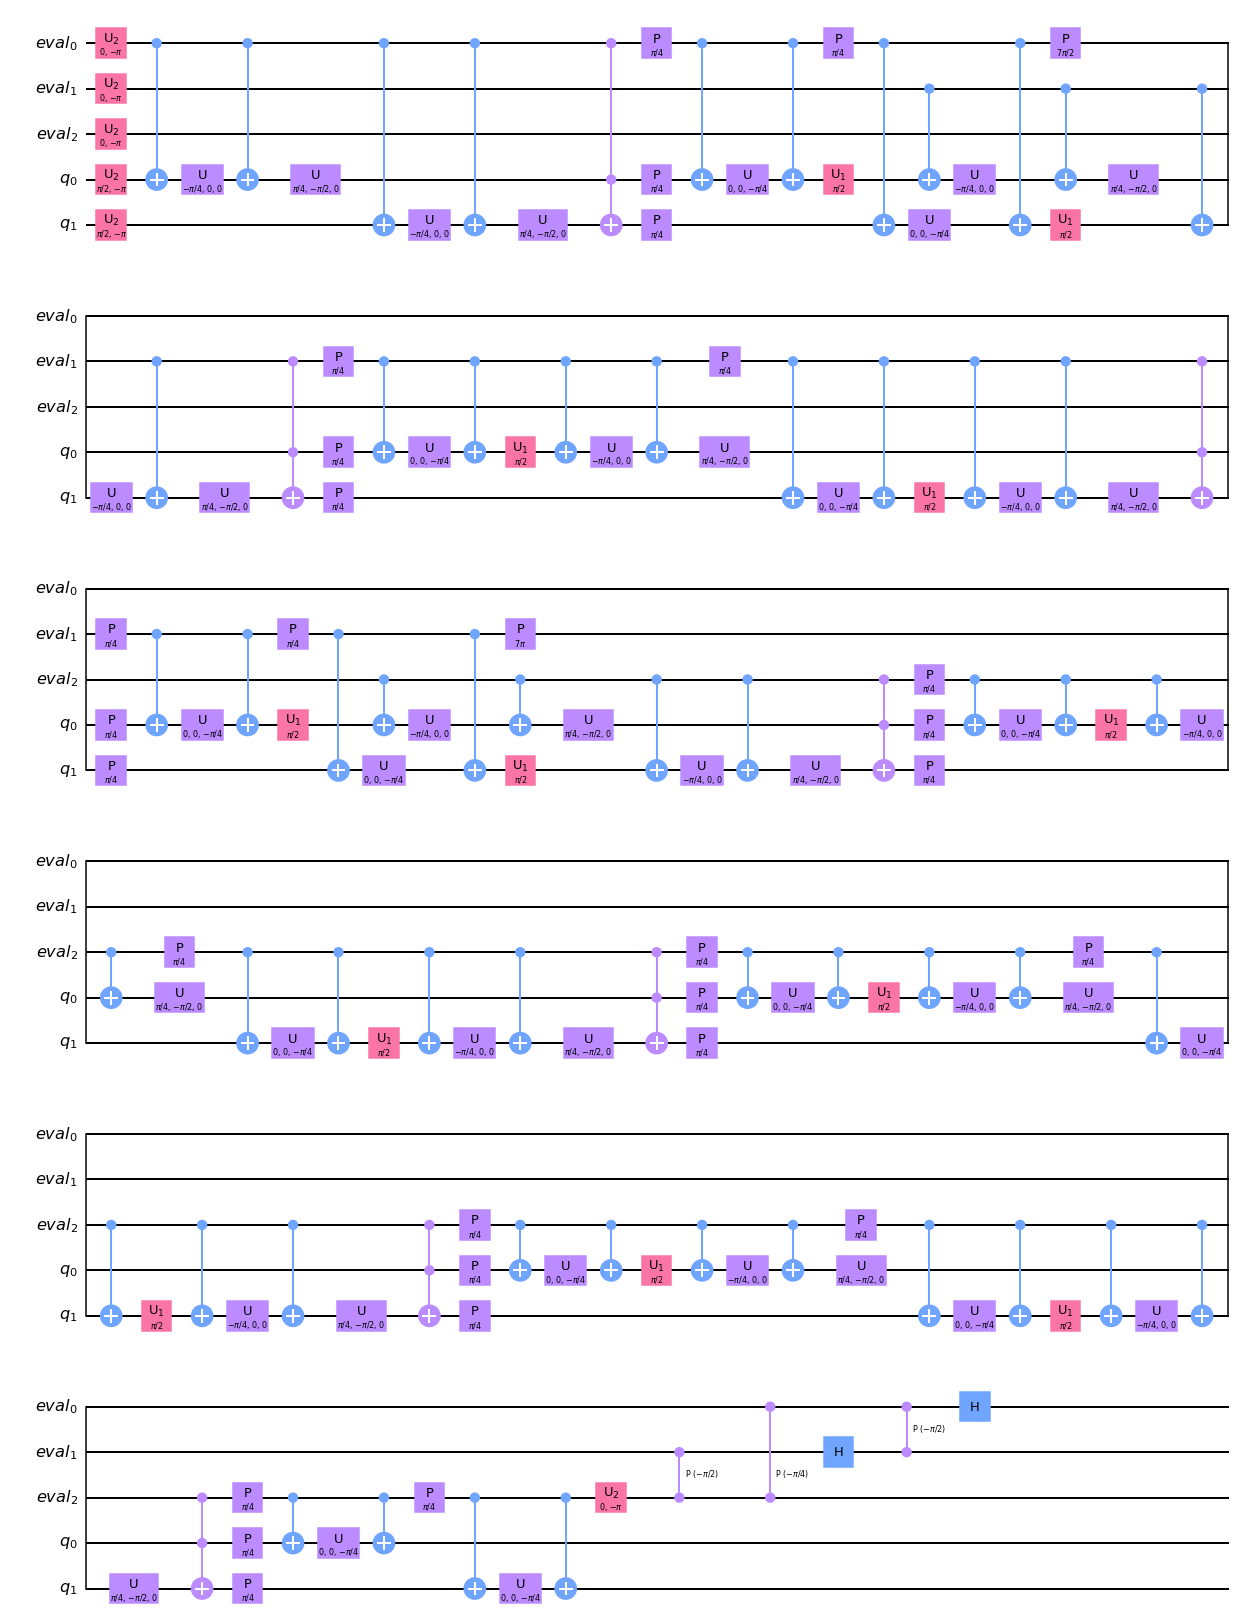

In [100]:
num_evaluation_qubits = 3

qasm_backend = AerProvider().get_backend("qasm_simulator")
qpe = PhaseEstimation(num_evaluation_qubits=num_evaluation_qubits,
                      quantum_instance=QuantumInstance(backend=qasm_backend,
                                                       shots=4096,
                                                       optimization_level=3))

ckt = qpe.construct_circuit(unitary_circuit, state_preparation=state_prep)
ckt = transpile(ckt, backend=qasm_backend)
print(f"depth = {ckt.depth()}")
ckt.draw('mpl');

QPE 알고리즘을 실행하고 결과를 출력한다.

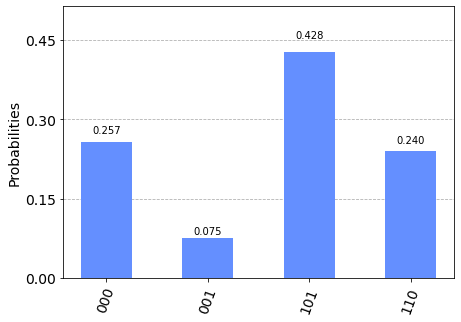

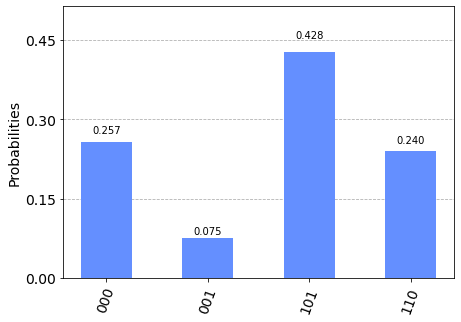

In [101]:
res = qpe.estimate(unitary_circuit, state_prep)
plot_histogram(res.phases)

In [102]:
phase_list = sorted(res.phases.keys(), key=lambda x: res.phases[x], reverse=True)
for p in phase_list[:4]:
    bin_p = int(p, 2) / 2**num_evaluation_qubits
    print(f"phase[rad] : {2*bin_p*np.pi}, occurence : {res.phases[p]}")

phase[rad] : 3.9269908169872414, occurence : 0.427978515625
phase[rad] : 0.0, occurence : 0.257080078125
phase[rad] : 4.71238898038469, occurence : 0.239990234375
phase[rad] : 0.7853981633974483, occurence : 0.074951171875


실험으로 얻은 값을 비교하기 위해 unitary simulator를 이용하여 unitary 회로의 행렬 형태를 얻은 뒤, eigen problem의 해를 구한다.

In [103]:
unitary_simulator = AerProvider().get_backend('unitary_simulator')
job_unitary = unitary_simulator.run(unitary_circuit)
mat = job_unitary.result().get_unitary()
print(mat)

[[ 5.55111512e-17-5.00000000e-01j -5.00000000e-01-1.11022302e-16j
  -5.00000000e-01-1.11022302e-16j -8.32667268e-17+5.00000000e-01j]
 [-5.00000000e-01+0.00000000e+00j  0.00000000e+00-5.00000000e-01j
   0.00000000e+00-5.00000000e-01j  5.00000000e-01+0.00000000e+00j]
 [ 0.00000000e+00-5.00000000e-01j -5.00000000e-01+0.00000000e+00j
   5.00000000e-01+0.00000000e+00j  0.00000000e+00-5.00000000e-01j]
 [ 5.00000000e-01-1.11022302e-16j  5.55111512e-17+5.00000000e-01j
  -8.32667268e-17-5.00000000e-01j  5.00000000e-01-1.11022302e-16j]]


In [104]:
eigval, eigvec = np.linalg.eig(mat)
assert all(np.isclose(np.abs(eigval), 1.0))
eigph = np.angle(eigval)
for i, p in enumerate(eigph):
    if p < 0:
        eigph[i] = 2*np.pi + p
print("eig phase = ", eigph)
for i, v in enumerate(eigvec):
    print(f"eigvec {i} = {v/np.linalg.norm(v, ord=2)}")

eig phase =  [3.92699082e+00 4.71238898e+00 2.08767645e-16 7.85398163e-01]
eigvec 0 = [ 6.53281482e-01+0.00000000e+00j -2.51781455e-16-5.00000000e-01j
  5.00000000e-01+0.00000000e+00j -2.70598050e-01+7.24755364e-17j]
eigvec 1 = [ 6.53281482e-01+1.37661810e-16j  5.07774975e-17+5.00000000e-01j
 -5.00000000e-01-1.85423854e-16j -2.70598050e-01+1.77524568e-17j]
eigvec 2 = [ 2.70598050e-01-1.74311524e-16j  5.00000000e-01+4.52157710e-17j
 -5.44450361e-16-5.00000000e-01j  6.53281482e-01+0.00000000e+00j]
eigvec 3 = [-2.70598050e-01-5.87812805e-17j  5.00000000e-01+0.00000000e+00j
  1.90001103e-16-5.00000000e-01j -6.53281482e-01+3.16130003e-16j]


### (추가) Transpile optimization
fake rome backend를 활용하여 transpile optimization 과정의 차이를 살펴보겠습니다.

In [105]:
from qiskit.test.mock import FakeRome
fake_rome = FakeRome()

# 측정게이트 추가
eval_qubits = ckt.qregs[0]
creg = ClassicalRegister(len(eval_qubits))
ckt.add_register(creg)
ckt.measure(eval_qubits, creg)

In [106]:
ckt_lv0 = transpile(ckt, backend=fake_rome, optimization_level=0)
ckt_lv1 = transpile(ckt, backend=fake_rome, optimization_level=1)
ckt_lv2 = transpile(ckt, backend=fake_rome, optimization_level=2)
ckt_lv3 = transpile(ckt, backend=fake_rome, optimization_level=3)

In [107]:
for i, ckt_opt in enumerate([ckt_lv0, ckt_lv1, ckt_lv2, ckt_lv3]):
    cnot_count = ckt_opt.count_ops()['cx'] if 'cx' in ckt_opt.count_ops() else 0
    print(f"opt_level={i}, depth={ckt_opt.depth()}, cnot_count={cnot_count}")

opt_level=0, depth=516, cnot_count=200
opt_level=1, depth=327, cnot_count=190
opt_level=2, depth=323, cnot_count=199
opt_level=3, depth=293, cnot_count=141
